# Home Alarm Company - Customer Lifetime Value (CLV) Analysis

Customer LifeTime Value is the expected profit per customer discounted to current timeframe incorporting likelihood of customer attrition over time. This project performs the analysis on two subscription models of a company that sells a home security service on a monthly subscription basis. 


## Goal

Assess the CLV across the two models and calculate the benefit to company from one subscription model compared to the other and suggest actions to incentivize customer to switch from one subscription model to the other.

In [2]:
from IPython.display import HTML

HTML('''

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="Show Python 3 Code">
</form>''')

## The Data
(courtesy Vincent Nijs - Rady School of Management - University of California San Diego)

Annual revenue per customer from security service: \\$480 (payment is monthly)  <br>
Annual discount rate for cash flow: 10%    <br>
Annual service cost per customer: $72   <br> 
Annual marketing cost per customer to promote service: \\$24    <br>
Annual growth rate of revenue and annual increase of marketing, service costs: 3%    <br>

Attrition/churn rates (%/100) for the two models (autopay vs. non-autopaying):

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

churn = pd.DataFrame(
    {
        "autopay": [0.032, 0.070, 0.097, 0.103, 0.095, 0.078, 0.069, 0.059, 0.053],
        "no_autopay": [0.084, 0.122, 0.162, 0.154, 0.134, 0.120, 0.111, 0.096, 0.086],
    }
)

churn

,autopay,no_autopay
0,0.032,0.084
1,0.070,0.122
2,0.097,0.162
3,0.103,0.154
4,0.095,0.134
5,0.078,0.120
6,0.069,0.111
7,0.059,0.096
8,0.053,0.086


## Methodology

:- revenue is monthly and hence discounting if cash flow needs to be monthly <br>
:- revenue, costs (mktg and service) are constant for 12 months in the year, and change of rate applies at end of a year <br>
:- customers who have been in service are assessed in this methodology and their CLV is estimated for Service Years: 2 to 8 <br>
:- customers are on a yearly contract and decide whether to stay subscribed or not (thus churn is optimistic, i.e., assessed at end of year) <br>
:- customers pay is due at end of billing period (thus discounting is pessimistic, i.e., even first payment should be discounted by a month) <br>

## Analysis

In [19]:
# calculate clv here
growth = 1.03
monthly_disc_rate = (1 + 0.1) ** (1 / 12) - 1
month_rev = (
    [40] * 12
    + [40 * growth] * 12
    + [40 * growth ** 2] * 12
    + [40 * growth ** 3] * 12
    + [40 * growth ** 4] * 12
    + [40 * growth ** 5] * 12
    + [40 * growth ** 6] * 12
    + [40 * growth ** 7] * 12
)
service_cost = (
    [6] * 12
    + [6 * growth] * 12
    + [6 * growth ** 2] * 12
    + [6 * growth ** 3] * 12
    + [6 * growth ** 4] * 12
    + [6 * growth ** 5] * 12
    + [6 * growth ** 6] * 12
    + [6 * growth ** 7] * 12
)
mktg_cost = (
    [2] * 12
    + [2 * growth] * 12
    + [2 * growth ** 2] * 12
    + [2 * growth ** 3] * 12
    + [2 * growth ** 4] * 12
    + [2 * growth ** 5] * 12
    + [2 * growth ** 6] * 12
    + [2 * growth ** 7] * 12
)
autopay_churn = [[item] * 12 for item in churn["autopay"][0:8]]
autopay_churn = sum(autopay_churn, [])
autopay_churn[0:12] = [0] * 12

CLV_autopay = pd.DataFrame(
    {
        "month_rev": month_rev,
        "service_cost": service_cost,
        "mktg_cost": mktg_cost,
        "autopay_churn": autopay_churn,
    }
)

CLV_autopay["autopay_ret"] = 1 - CLV_autopay["autopay_churn"]

CLV_autopay["prob_active"] = CLV_autopay["autopay_ret"]

for ctr in range(12, 95, 12):
    CLV_autopay["prob_active"].loc[ctr : ctr + 11] = np.array(
        CLV_autopay["autopay_ret"].loc[ctr : ctr + 11]
    ) * np.array(CLV_autopay["prob_active"].loc[ctr - 12 : ctr - 1])


CLV_autopay["discountperiod"] = range(1, 97, 1)

CLV_autopay["PV_profit"] = (
    (CLV_autopay["month_rev"] - CLV_autopay["service_cost"] - CLV_autopay["mktg_cost"])
    * CLV_autopay["prob_active"]
    / (1 + monthly_disc_rate) ** CLV_autopay["discountperiod"]
)

CLV_autopay["CLV"] = CLV_autopay["PV_profit"].cumsum(axis=0)

clv_autopay_sum = sum(CLV_autopay["PV_profit"])

In [20]:
CLV_autopay

,month_rev,service_cost,mktg_cost,autopay_churn,autopay_ret,prob_active,discountperiod,PV_profit,CLV
0,40.000000,6.000000,2.000000,0.000,1.000,1.000000,1,31.746846,31.746846
1,40.000000,6.000000,2.000000,0.000,1.000,1.000000,2,31.495695,63.242541
2,40.000000,6.000000,2.000000,0.000,1.000,1.000000,3,31.246531,94.489072
3,40.000000,6.000000,2.000000,0.000,1.000,1.000000,4,30.999338,125.488410
4,40.000000,6.000000,2.000000,0.000,1.000,1.000000,5,30.754100,156.242510
...,...,...,...,...,...,...,...,...,...
91,49.194955,7.379243,2.459748,0.059,0.941,0.550658,92,10.436349,1762.733926
92,49.194955,7.379243,2.459748,0.059,0.941,0.550658,93,10.353786,1773.087712
93,49.194955,7.379243,2.459748,0.059,0.941,0.550658,94,10.271877,1783.359589
94,49.194955,7.379243,2.459748,0.059,0.941,0.550658,95,10.190615,1793.550204


In [21]:
f"""CLV over the 8 year period for the customer on autopay is $ {round(CLV_autopay.CLV[95],2)}"""

'CLV over the 8 year period for the customer on autopay is $ 1803.66'

In [22]:
# calculate clv here

growth = 1.03
monthly_disc_rate = (1 + 0.1) ** (1 / 12) - 1
month_rev = (
    [40] * 12
    + [40 * growth] * 12
    + [40 * growth ** 2] * 12
    + [40 * growth ** 3] * 12
    + [40 * growth ** 4] * 12
    + [40 * growth ** 5] * 12
    + [40 * growth ** 6] * 12
    + [40 * growth ** 7] * 12
)
service_cost = (
    [6] * 12
    + [6 * growth] * 12
    + [6 * growth ** 2] * 12
    + [6 * growth ** 3] * 12
    + [6 * growth ** 4] * 12
    + [6 * growth ** 5] * 12
    + [6 * growth ** 6] * 12
    + [6 * growth ** 7] * 12
)
mktg_cost = (
    [2] * 12
    + [2 * growth] * 12
    + [2 * growth ** 2] * 12
    + [2 * growth ** 3] * 12
    + [2 * growth ** 4] * 12
    + [2 * growth ** 5] * 12
    + [2 * growth ** 6] * 12
    + [2 * growth ** 7] * 12
)
no_autopay_churn = [[item] * 12 for item in churn["no_autopay"][0:8]]
no_autopay_churn = sum(no_autopay_churn, [])
no_autopay_churn[0:12] = [0] * 12

CLV_no_autopay = pd.DataFrame(
    {
        "month_rev": month_rev,
        "service_cost": service_cost,
        "mktg_cost": mktg_cost,
        "no_autopay_churn": no_autopay_churn,
    }
)

CLV_no_autopay["autopay_ret"] = 1 - CLV_no_autopay["no_autopay_churn"]

CLV_no_autopay["prob_active"] = CLV_no_autopay["autopay_ret"]

for ctr in range(12, 95, 12):
    CLV_no_autopay["prob_active"].loc[ctr : ctr + 11] = np.array(
        CLV_no_autopay["autopay_ret"].loc[ctr : ctr + 11]
    ) * np.array(CLV_no_autopay["prob_active"].loc[ctr - 12 : ctr - 1])


CLV_no_autopay["discountperiod"] = range(1, 97, 1)

CLV_no_autopay["PV_profit"] = (
    (
        CLV_no_autopay["month_rev"]
        - CLV_no_autopay["service_cost"]
        - CLV_no_autopay["mktg_cost"]
    )
    * CLV_no_autopay["prob_active"]
    / (1 + monthly_disc_rate) ** CLV_no_autopay["discountperiod"]
)

CLV_no_autopay["CLV"] = CLV_no_autopay["PV_profit"].cumsum(axis=0)

clv_no_autopay_sum = sum(CLV_no_autopay["PV_profit"])

In [23]:
CLV_no_autopay

,month_rev,service_cost,mktg_cost,no_autopay_churn,autopay_ret,prob_active,discountperiod,PV_profit,CLV
0,40.000000,6.000000,2.000000,0.000,1.000,1.000000,1,31.746846,31.746846
1,40.000000,6.000000,2.000000,0.000,1.000,1.000000,2,31.495695,63.242541
2,40.000000,6.000000,2.000000,0.000,1.000,1.000000,3,31.246531,94.489072
3,40.000000,6.000000,2.000000,0.000,1.000,1.000000,4,30.999338,125.488410
4,40.000000,6.000000,2.000000,0.000,1.000,1.000000,5,30.754100,156.242510
...,...,...,...,...,...,...,...,...,...
91,49.194955,7.379243,2.459748,0.096,0.904,0.381223,92,7.225140,1525.389453
92,49.194955,7.379243,2.459748,0.096,0.904,0.381223,93,7.167982,1532.557435
93,49.194955,7.379243,2.459748,0.096,0.904,0.381223,94,7.111275,1539.668710
94,49.194955,7.379243,2.459748,0.096,0.904,0.381223,95,7.055018,1546.723728


In [24]:
f"""CLV over the 8 year period for the customer on not on autopay is $ {round(CLV_no_autopay.CLV[95],2)}"""

'CLV over the 8 year period for the customer on not on autopay is $ 1553.72'

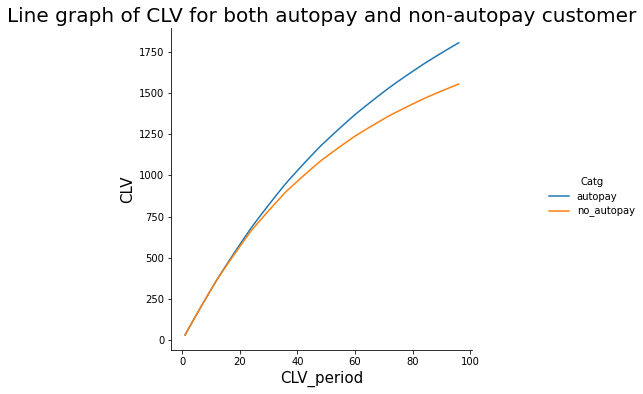

In [25]:
# enter your code here

autopay_graph_tab = pd.DataFrame(
    {
        "CLV_period": range(1, 97, 1),
        "CLV": CLV_autopay["CLV"],
        "Ret_rate": CLV_autopay["prob_active"],
        "Catg": ["autopay"] * 96,
    }
)
no_autopay_graph_tab = pd.DataFrame(
    {
        "CLV_period": range(1, 97, 1),
        "CLV": CLV_no_autopay["CLV"],
        "Ret_rate": CLV_no_autopay["prob_active"],
        "Catg": ["no_autopay"] * 96,
    }
)

tab = pd.concat([autopay_graph_tab, no_autopay_graph_tab], axis=0)

sns.relplot(x="CLV_period", y="CLV", data=tab, kind="line", hue="Catg")

plt.title("Line graph of CLV for both autopay and non-autopay customer", fontsize=20)
plt.xlabel("CLV_period", fontsize=15)
plt.ylabel("CLV", fontsize=15)
plt.show()

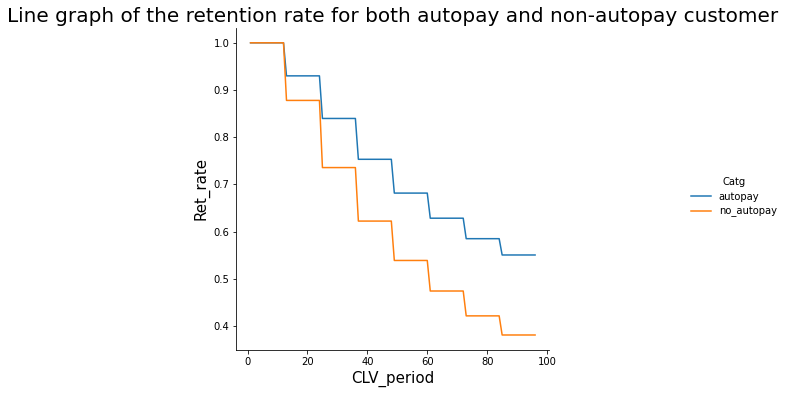

In [26]:
# enter your code here

sns.relplot(x="CLV_period", y="Ret_rate", data=tab, kind="line", hue="Catg")

plt.title(
    "Line graph of the retention rate for both autopay and non-autopay customer",
    fontsize=20,
)
plt.xlabel("CLV_period", fontsize=15)
plt.ylabel("Ret_rate", fontsize=15)
plt.show()

#### Benefit to company from a customer on autopay compared to a customer not on autopay subscription model

In [27]:
max_pay = round(clv_autopay_sum - clv_no_autopay_sum, 2)
year3_clvgain = round(
    sum(CLV_autopay.PV_profit[13:25]) - sum(CLV_no_autopay.PV_profit[13:25]), 2
)
year4_clvgain = round(
    sum(CLV_autopay.PV_profit[25:37]) - sum(CLV_no_autopay.PV_profit[25:37]), 2
)
print("$", round(max_pay, 2))

$ 249.94


### Recommended marketing actions

Home Alarm can consider the following to convert existing customers (i.e. non autopay) to autopay who are about to start their second year with Home Alarm. 

1.) Every customer switching from non-autopay to autopay, represents \$250 in additional lifetime value. Assuming 10000 customers, can be switched, that amounts to $2.5 million, providing no incentive was needed to make that switch. If company desires to keep as much of this additional CLV gain as possible, it would be worthwhile to look at some low cost messaging/advertising to sell the idea of the autopay benefit to the customer (eg. time saving, hassle free) without needing to give \\$ incentives, but it would have to be determined if enough people would switch at the end of the advertising.

2.) A late fee penalty if not available already, could convince customers to switch to autopay and not miss paying ontime.

3.) After conclusion of 3rd service year (i.e. 2nd CLV period), CLV gain from autopay is \$19, the next year gain is \$34. When a customer comes to renew subscription for the 2nd year, a month's payment of \$40 can be waived as an incentive to a customer if they switch to autopay.